In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nuaih-plant-classification/Sample_Submission.csv
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/train.csv
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test.csv
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/4c00a061-3245-4e69-9a3f-a88a3241f141___Rutg._HL 2426.JPG
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/5d5c0b73-9209-4901-994d-07bd2624e12d___Mary_HL 9134.JPG
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/cf9ea9fa-b6c6-412a-9b65-eac52390b5ce___RS_HL 4612.JPG
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/5cb1014e-dd7c-4d7b-8e8f-23326179dc23___Mary_HL 6383.JPG
/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/4a592d90-1902-4b88-acb2-b3b5b746c

## Importing 

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
%matplotlib inline

## Loading the csv file into pandas dataframe

In [3]:
df = pd.read_csv("/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/train.csv")
df.head()

,Filename,Label
0,00166615-5e7b-4318-8957-5e50df335ee8___RS_HL 1...,0
1,00532378-bfb2-4d3b-8b19-903ecc085624___RS_HL 2...,0
2,0055dd26-23a7-4415-ac61-e0b44ebfaf80___RS_HL 5...,0
3,00907d8b-6ae6-4306-bfd7-d54471981a86___RS_HL 5...,0
4,0098dbd9-286a-4d6a-bf4b-5459d66f88c0___RS_HL 5...,0


In [4]:
df.isna().any()

Filename    False
Label       False
dtype: bool

In [5]:
base = len(df[df["Label"]==0])
base

2557

In [6]:
want_to_balance = len(df[df["Label"]==1])
want_to_balance

7111

In [7]:
diff = want_to_balance-0.75*base
int(diff)

5193

In [8]:
df.isnull().sum()

Filename    0
Label       0
dtype: int64

## Loading and preprocessing

In [9]:
train_dir = "/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/train/"

In [10]:
features = []
targets = []
for file_name in os.listdir(train_dir):
    img = plt.imread(train_dir+file_name)
    df_dash = df[df["Filename"]== file_name]
    #img = cv2.resize(img,INPUT_SHAPE)
    features.append(np.array(img))
    if df_dash["Label"].item() == 0:
        targets.append(0)
    elif df_dash["Label"].item() == 1:
        targets.append(1)
    else:
        print("error")
    
    

In [11]:
assert len(features) == len(targets)
assert len(features) == len(df)

## Visualizng some images after being preprocessed

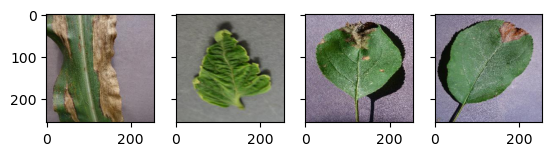

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
ax1.imshow(features[0])
ax2.imshow(features[100])
ax3.imshow(features[200])
ax4.imshow(features[1000])

<AxesSubplot:xlabel='Label', ylabel='count'>

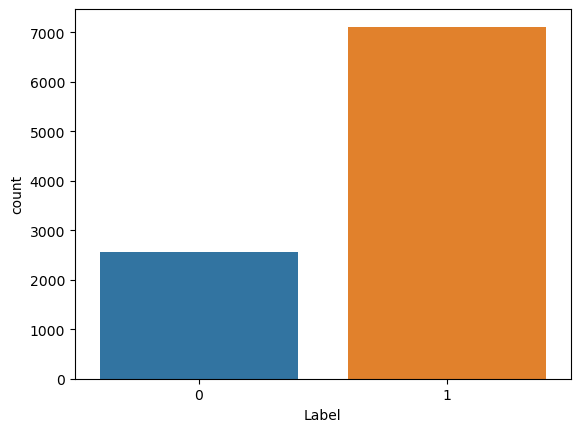

In [13]:
import seaborn as sns
sns.countplot(x='Label' , data = df)

In [14]:
from keras.preprocessing.image import ImageDataGenerator
small_class=[]
datagen1 = ImageDataGenerator(
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=False,
        fill_mode='nearest')
for i in range(len(targets)):
    if(targets[i]==0):
        y=features[i]
        y = y.reshape((1,) + y.shape)  # this is a Numpy array with 4dim

    else:
        continue
    j = 0
    for batch in datagen1.flow(y, batch_size=1):
        if len(small_class) == int(diff):
            break;
        small_class.append(y)
        print(len(small_class))
        j += 1
        if j > 10:
            break 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [15]:
small_class = small_class[:int(diff)]

In [16]:
small_labels = np.zeros((len(small_class),), dtype=int)

In [17]:
features = np.array(features)

In [18]:
targets = np.concatenate((np.array(targets),small_labels))
len(targets)

14861

In [19]:
small_class = np.array(small_class)

In [20]:
features.shape

(9668, 256, 256, 3)

In [21]:
targets.shape

(14861,)

In [22]:
small_class = small_class[:,0,:,:]

In [23]:
small_class[0].shape

(256, 256, 3)

In [24]:
features = np.concatenate((features, small_class))

In [25]:
features.shape

(14861, 256, 256, 3)

In [26]:
del small_labels, small_class

In [27]:
len(targets) == len(features)

True

(array([7750.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7111.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

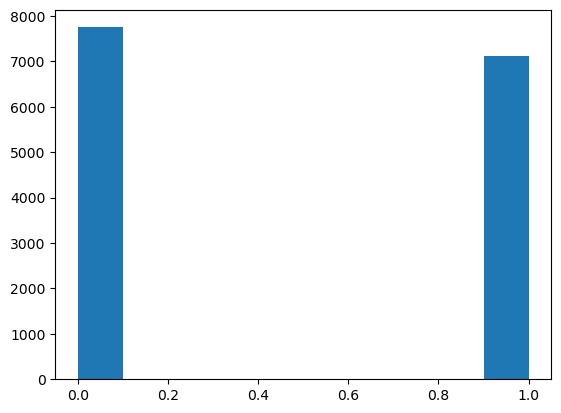

In [28]:
plt.hist(targets)

## Splitting the data into training and validation data

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(features, targets, random_state = 0 , stratify = targets, test_size=0.3)

In [30]:
del features, targets

In [31]:
INPUT_SIZE = 256

## Building the model

In [32]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Reshape, Multiply, Add

def EfficientNetB0(input_shape=(256, 256, 3), num_classes=2, dropout_rate=0.2):
    def conv_block(inputs, filters, kernel_size, strides, padding='same', use_bias=False):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(inputs)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)
        return x

    def mb_conv_block(inputs, filters, kernel_size, strides, expand_ratio, se_ratio=0.25):
        # Expansion phase
        in_channels = inputs.shape[-1]
        expanded_channels = in_channels * expand_ratio
        if expand_ratio != 1:
            x = conv_block(inputs, expanded_channels, kernel_size=(1, 1), strides=(1, 1))
        else:
            x = inputs

        # Depthwise convolution phase
        x = Conv2D(expanded_channels, kernel_size, strides=strides, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('swish')(x)

        # Squeeze and Excitation phase
        num_reduced_filters = max(1, int(in_channels * se_ratio))
        se = GlobalAveragePooling2D()(x)
        se = Dense(num_reduced_filters, activation='swish')(se)
        se = Dense(expanded_channels, activation='sigmoid')(se)
        se = Reshape((1, 1, expanded_channels))(se)
        x = Multiply()([x, se])

        # Output phase
        x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        if strides == (1, 1) and in_channels == filters:
            x = Add()([x, inputs])
        return x

    inputs = Input(shape=input_shape)

    x = conv_block(inputs, filters=32, kernel_size=(3, 3), strides=(2, 2), padding='valid')

    x = mb_conv_block(x, filters=16, kernel_size=(3, 3), strides=(1, 1), expand_ratio=1)
    x = mb_conv_block(x, filters=24, kernel_size=(3, 3), strides=(2, 2), expand_ratio=6)
    x = mb_conv_block(x, filters=40, kernel_size=(5, 5), strides=(2, 2), expand_ratio=6)
    x = mb_conv_block(x, filters=80, kernel_size=(3, 3), strides=(2, 2), expand_ratio=6)
    x = mb_conv_block(x, filters=112, kernel_size=(5, 5), strides=(1, 1), expand_ratio=6)
    x = mb_conv_block(x, filters=192, kernel_size=(5, 5), strides=(2, 2), expand_ratio=6)
    x = mb_conv_block(x, filters=320, kernel_size=(3, 3), strides=(1, 1), expand_ratio=6)

    x = conv_block(x, filters=1280, kernel_size=(1, 1),strides=(1, 1), padding='same')
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [33]:
model = EfficientNetB0()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=15,verbose=1,epochs=20
          , validation_data=(x_valid,y_valid),
          shuffle=False)

2023-02-18 05:37:55.682032: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2045116416 exceeds 10% of free system memory.
2023-02-18 05:37:58.012088: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2045116416 exceeds 10% of free system memory.


Epoch 1/20
694/694 [==============================] - ETA: 0s - loss: 0.3589 - accuracy: 0.8387

2023-02-18 05:40:21.032959: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 876675072 exceeds 10% of free system memory.


694/694 [==============================] - 158s 209ms/step - loss: 0.3589 - accuracy: 0.8387 - val_loss: 0.2056 - val_accuracy: 0.9235
Epoch 2/20
694/694 [==============================] - 144s 207ms/step - loss: 0.1432 - accuracy: 0.9470 - val_loss: 0.2761 - val_accuracy: 0.9022
Epoch 3/20
694/694 [==============================] - 144s 207ms/step - loss: 0.0915 - accuracy: 0.9658 - val_loss: 0.1212 - val_accuracy: 0.9599
Epoch 4/20
694/694 [==============================] - 144s 207ms/step - loss: 0.0701 - accuracy: 0.9750 - val_loss: 0.1019 - val_accuracy: 0.9688
Epoch 5/20
694/694 [==============================] - 144s 207ms/step - loss: 0.0571 - accuracy: 0.9793 - val_loss: 0.1480 - val_accuracy: 0.9507
Epoch 6/20
694/694 [==============================] - 149s 215ms/step - loss: 0.0525 - accuracy: 0.9813 - val_loss: 0.0578 - val_accuracy: 0.9791
Epoch 7/20
694/694 [==============================] - 144s 207ms/step - loss: 0.0473 - accuracy: 0.9833 - val_loss: 0.0923 - val_accura

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [35]:
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [36]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()

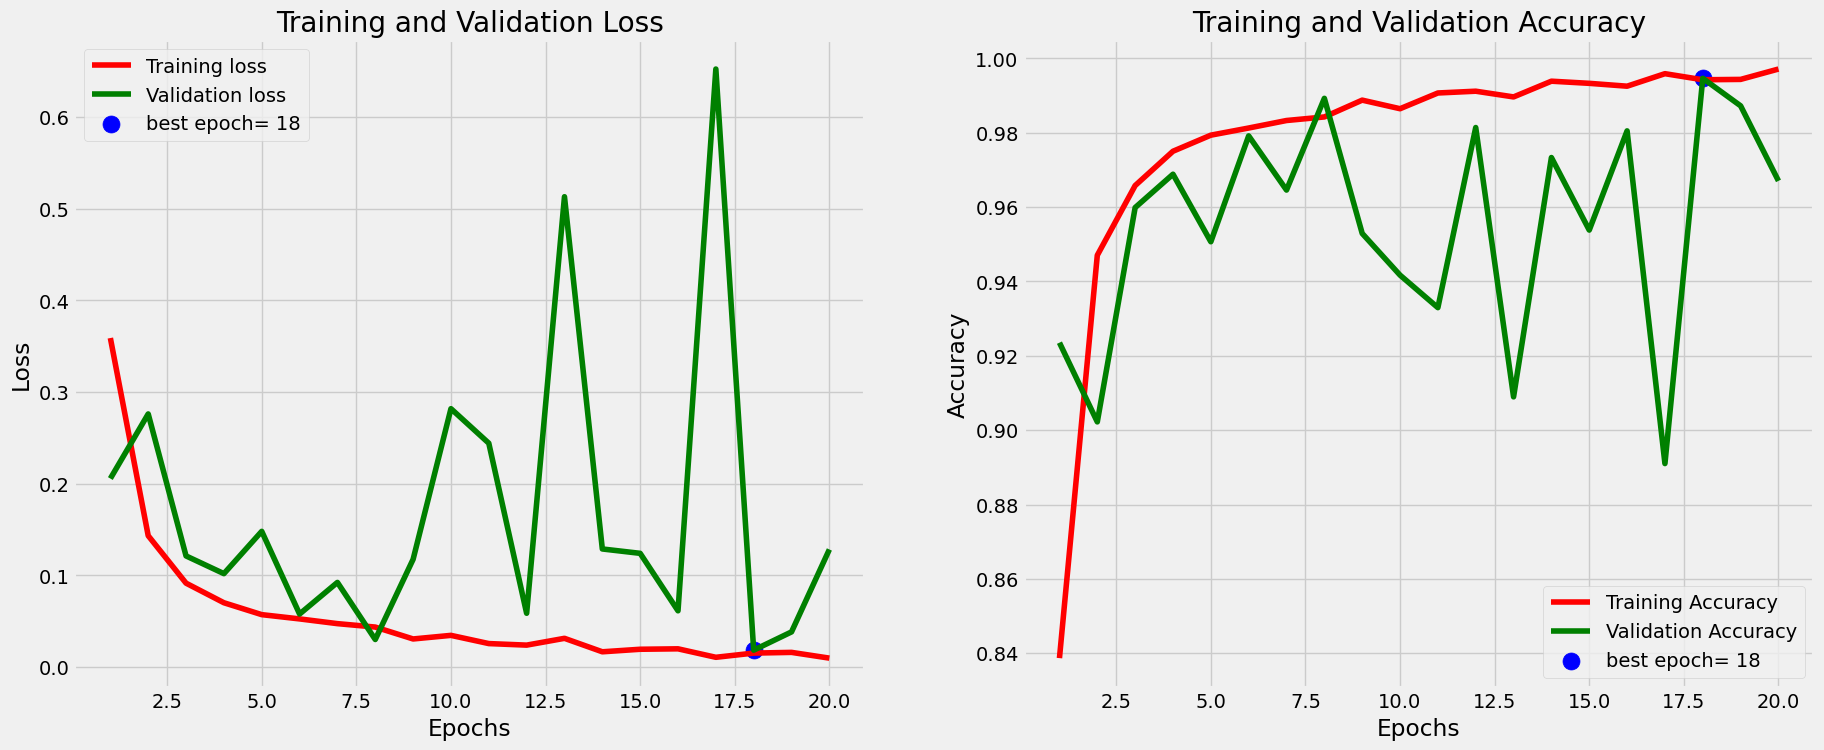

In [37]:
tr_plot(history,0)

## وه

## predictions

In [38]:
path = "/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test/"

In [39]:
df_t = pd.read_csv("/kaggle/input/nuaih-plant-classification/PlantFinal Files-20230213T190104Z-001/Final Files/test.csv")
df_t.head(5)

,Filename,Label
0,0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4...,NaN
1,002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9...,NaN
2,0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9...,NaN
3,005f183c-0a73-4738-91f7-c0a0e02cd9e3___JR_HL 9...,NaN
4,0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4...,NaN


In [40]:
test_set = []
for file_name in os.listdir(path):
    img = plt.imread(path+file_name)
    df_dash_t = df_t[df_t["Filename"]== file_name]
    test_set.append(np.array(img))

In [41]:
assert len(test_set)==len(df_t)

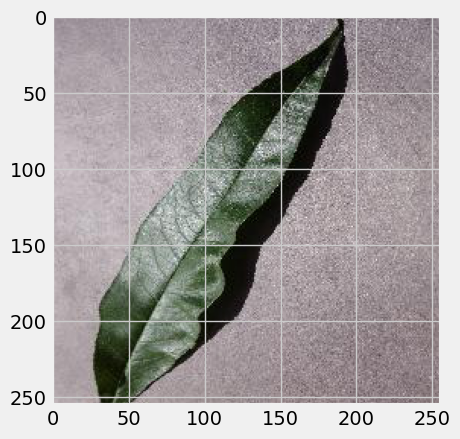

In [42]:
plt.imshow(test_set[4])

In [43]:
x_test = np.array(test_set)
pred = model.predict(x_test) 

44/44 [==============================] - 7s 112ms/step


In [44]:
pred

array([[6.7938687e-03],
       [4.3726769e-09],
       [2.2809452e-09],
       ...,
       [9.9071878e-01],
       [5.6612869e-13],
       [1.2815810e-05]], dtype=float32)

In [45]:
pd.read_csv("/kaggle/input/nuaih-plant-classification/Sample_Submission.csv")

,Filename,Label
0,0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4...,0.0
1,002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9...,1.0
2,0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9...,1.0
3,005f183c-0a73-4738-91f7-c0a0e02cd9e3___JR_HL 9...,0.0
4,0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4...,1.0
...,...,...
1248,NaN,NaN
1249,NaN,NaN
1250,NaN,NaN
1251,NaN,NaN


In [46]:
df_t["Label"] = np.round_(pred)
df_t

,Filename,Label
0,0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4...,0.0
1,002efba9-09b3-43de-93b7-5c2460185cde___JR_HL 9...,0.0
2,0048afb8-b950-4c57-9e72-7e26282327ee___JR_HL 9...,0.0
3,005f183c-0a73-4738-91f7-c0a0e02cd9e3___JR_HL 9...,0.0
4,0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4...,1.0
...,...,...
1395,d64caa8b-50d9-46a7-99cb-dacf615b687b___UF.Citr...,0.0
1396,d651366b-66df-4fe4-8e31-2ae14abf5035___UF.Citr...,1.0
1397,d65dd7cb-75f7-4479-885b-56205d46aa4a___CREC_HL...,1.0
1398,d66992ca-793c-4200-933f-2e6950213c86___UF.Citr...,0.0


In [47]:
df_t.to_csv('submission.csv')